**Importing Required Libraries**

In [1]:
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os

**Libraries required for connecting to IBM Db2 database on the cloud**


In [2]:
!pip3 install --user lazy
!pip3 install --user jaydebeapi
!pip3 uninstall --yes ibmdbpy
!pip3 install ibmdbpy --user --ignore-installed --no-deps
!wget -O $HOME/.local/lib/python3.8/site-packages/ibmdbpy/db2jcc4.jar https://ibm.box.com/shared/static/lmhzyeslp1rqns04ue8dnhz2x7fb6nkc.zip

Found existing installation: ibmdbpy 0.1.6
Uninstalling ibmdbpy-0.1.6:
  Successfully uninstalled ibmdbpy-0.1.6
  Using cached ibmdbpy-0.1.6-py2.py3-none-any.whl (148 kB)
--2020-06-29 19:03:49--  https://ibm.box.com/shared/static/lmhzyeslp1rqns04ue8dnhz2x7fb6nkc.zip
Resolving ibm.box.com (ibm.box.com)... 185.235.236.197
Connecting to ibm.box.com (ibm.box.com)|185.235.236.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/lmhzyeslp1rqns04ue8dnhz2x7fb6nkc.zip [following]
--2020-06-29 19:03:50--  https://ibm.box.com/public/static/lmhzyeslp1rqns04ue8dnhz2x7fb6nkc.zip
Reusing existing connection to ibm.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.ent.box.com/public/static/lmhzyeslp1rqns04ue8dnhz2x7fb6nkc.zip [following]
--2020-06-29 19:03:50--  https://ibm.ent.box.com/public/static/lmhzyeslp1rqns04ue8dnhz2x7fb6nkc.zip
Resolving ibm.ent.box.com (ibm.ent.box.com)... 185.235.236.201
C

**Setting bus limt**

In [3]:
bus_limit=200

**Loading various models for accurate and specialized time series prediction**

1.   Static Model
2.   Dynamic Model



In [4]:
static_model=load_model("model24hrspredict.h5")
dynamic_model=load_model("model2hrspredict(6hrsinput).h5")
static_scaler=pickle.load(open("scalernew.pkl",'rb'))
dynamic_scaler=pickle.load(open("scaler6hrswala.pkl",'rb'))

/home/mohitgurav/.local/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.2.post1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


**Function to print timetable for the day**

In [5]:
def schedule(prediction):
    sch=[]
    for i,j in enumerate(prediction):
        print(f"{int(round(j[0]/bus_limit))} AT {str(i).zfill(2)}:00")
        sch.append([int(round(j[0]/bus_limit)),i])
    return sch

**Function to handle special events which might have an effect on public transport**

In [6]:
def special_events(prediction):
    start=prediction['START']
    stop=prediction['STOP']
    magnitude=prediction['MAGNITUDE']
    prediction['TIMESERIES'][start:stop]=prediction['TIMESERIES'][start:stop]*(1.0+magnitude/100)
    return prediction

**Function to predict static time table for transport mobiles**

**Inputs:**
*   Data of past 24 hours
*   Dictionary for special timeseries

**Output:**
*   Schedule for the day

In [7]:
def static_time_table(data,special_timeseries=None):
    y_pred=static_model.predict(data)[0]
    if special_timeseries!=None:
        special_timeseries['TIMESERIES']=y_pred[0]
        y_pred=special_events(special_timeseries)['TIMESERIES']
    y_pred=static_scaler.inverse_transform(y_pred.reshape(-1,1))
    number=schedule(y_pred)
    return [number,y_pred]

**Connecting to IBM Db2 database on the cloud**

In [18]:
from db2 import Db2
db2 = Db2(table_name='INTERSTATE_TRAFFIC')

In [19]:
db2.last24hours()

array([ 696,  364,  335,  444,  802, 1175, 2002, 2882, 3701, 4049, 4429,
       4547, 4380, 4380, 4302, 4302, 4283, 4132, 3947, 3543, 2781, 2159,
       1450,  954])

In [20]:
db2.last6hours()

array([3947, 3543, 2781, 2159, 1450,  954])

In [21]:
db2.ida_traffic_pd.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


**Data cleaning**

In [12]:
db2.last6hours()

array([3947, 3543, 2781, 2159, 1450,  954])

In [13]:
db2.ida_traffic_pd.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


**Data cleaning**

In [8]:
data=pd.read_csv("../Dataset/Metro_Interstate_Traffic_Volume.csv")
data['date_time']=pd.to_datetime(data['date_time'],infer_datetime_format=True)
data=data.iloc[:,-2:]
data=data.set_index('date_time')

**Noramlization**

In [ ]:
data['traffic_volume']=static_scaler.fit_transform(data['traffic_volume'].values.reshape(-1,1))

**Timeseries Prediction**

2 AT 00:00
1 AT 01:00
1 AT 02:00
3 AT 03:00
7 AT 04:00
14 AT 05:00
19 AT 06:00
22 AT 07:00
22 AT 08:00
22 AT 09:00
22 AT 10:00
22 AT 11:00
22 AT 12:00
23 AT 13:00
23 AT 14:00
24 AT 15:00
24 AT 16:00
22 AT 17:00
20 AT 18:00
17 AT 19:00
16 AT 20:00
14 AT 21:00
12 AT 22:00
9 AT 23:00


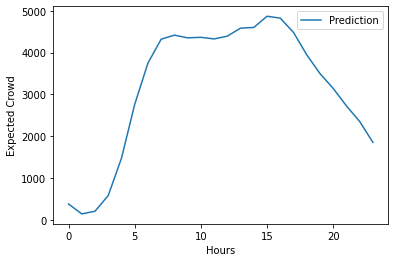

In [ ]:
num,pred=static_time_table(data['traffic_volume'][-24:].values.reshape(1,-1,1))
plt.plot(pred,label='Prediction')
plt.xlabel("Hours")
plt.ylabel("Expected Crowd")
plt.legend()

**Checking the dynamic model**

In [ ]:
data['traffic_volume']=dynamic_scaler.fit_transform(data['traffic_volume'].values.reshape(-1,1))
y_pred=dynamic_model.predict(data['traffic_volume'][-6:].values.reshape(1,-1,1))

**Converting the normalized data into original scale**

In [ ]:
y_pred=dynamic_scaler.inverse_transform(y_pred)

**Plotting the results**

In [ ]:
l=list(dynamic_scaler.inverse_transform(data['traffic_volume'][-6:].values.reshape(-1,1)))+list(y_pred[0])

**Adding legend and labels to graph**

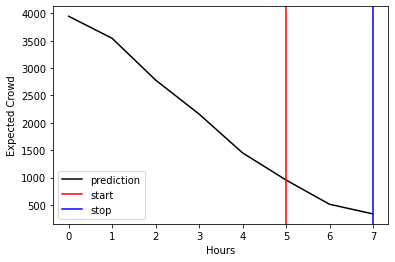

In [ ]:
plt.plot(l,color='black',label="prediction")
plt.axvline(5,color='r',label="start")
plt.axvline(7,color='blue',label="stop")
plt.xlabel("Hours")
plt.ylabel("Expected Crowd")
plt.legend()

**Function to predict dynamic changes in static timetable**

**Inputs:**
*   Data of past 6 hours

**Output:**
*   Crowd prediction for next 2 hours

In [ ]:
def dynamic_changes(data,sch,start_time):
    pred=dynamic_model.predict(data)[0]
    pred=schedule(dynamic_scaler.inverse_transform(pred.reshape(-1,1)))
    #temp=sch[start_time:start_time+2]
    sch[start_time:start_time+2]=list(map(lambda x:x[0],pred))
    return sch

In [ ]:
dynamic_changes(data['traffic_volume'][-6:].values.reshape(1,-1,1),list(map(lambda x:x[0],num)),0)

3 AT 00:00
2 AT 01:00


[3,
 2,
 1,
 3,
 7,
 14,
 19,
 22,
 22,
 22,
 22,
 22,
 22,
 23,
 23,
 24,
 24,
 22,
 20,
 17,
 16,
 14,
 12,
 9]